# Get data

In [226]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import talos as ta

* Read csv

In [227]:
r = ta.Reporting('FullTest_.csv')
len(r.data)

108

* Delete useless columns, Correct weird column swap bug

In [228]:
r.data = r.data.drop(['round_epochs', 'epochs', 'nb_features', 'optimizer', 'lambda_roll', 'lambda_yaw'], 1)

In [229]:
r.data["lambda_thrust"] = r.data["loss_func"]
r.data = r.data.drop("loss_func", 1) 

* Compute custom loss

In [230]:
# Compute the sum of our 4 losses, append it to df
r.data["sum_loss"] = r.data["val_roll_loss"] + r.data["val_pitch_loss"] + r.data["val_yaw_loss"] + r.data["val_pitch_loss"]

# Delete the 4 losses
new_cols = [c for c in r.data.columns if "loss" not in c.lower() or c.lower() == "sum_loss"]
r.data = r.data[new_cols]

* One-hot encode the string columns

In [231]:
r.data = r.data.rename(columns={'dense_layer': 'dense'})
def one_hot_encode(df, col_names):
    for name in col_names:
        df = df.join(pd.get_dummies(df[name], prefix=name))
        df = df.drop(name, 1)
    return df

col_names = ["cell", "dense"]
r.data = one_hot_encode(r.data, col_names)
r.data.head()

,lr,lambda_thrust,decay,dropout,nb_neurons,lr.1,nb_timesteps,batch_size,nb_layers,lambda_pitch,sum_loss,cell_gru,cell_lstm,dense_False,dense_True
0,0.00001,100.0,0.00001,0.1,256,0.001,12,8,4,10.0,0.061699,0,1,0,1
1,0.00001,100.0,0.00001,0.1,256,0.001,8,32,3,10.0,0.060742,1,0,0,1
2,0.00001,100.0,0.00001,0.1,128,0.001,4,8,2,100.0,0.059233,0,1,1,0
3,0.00001,100.0,0.00001,0.1,128,0.001,6,8,2,100.0,0.059772,0,1,1,0
4,0.00001,100.0,0.00001,0.1,64,0.001,12,32,3,100.0,0.067913,0,1,1,0


* Only keep uniques

In [232]:
r.data = r.data[[c for c
        in list(r.data)
        if len(r.data[c].unique()) > 1]]

# Display best combination

In [233]:
# get the highest result for our loss
r.low('sum_loss')

0.051730226648942335

In [234]:
# get the best paramaters
r.best_params('sum_loss', n=5, ascending=True)

array([[  0.,   1., 100.,   0.,  10.,   3., 512., 100.,  32.,   0.,   1.,
          0.],
       [  0.,   1.,  10.,   0.,  10.,   4., 256., 100.,  16.,   0.,   1.,
          1.],
       [  1.,   1.,  10.,   0.,   6.,   3., 256., 100.,  16.,   0.,   0.,
          2.],
       [  1.,   1., 100.,   0.,   6.,   2., 256., 100.,   8.,   0.,   0.,
          3.],
       [  0.,   0.,  10.,   1.,  12.,   2., 256., 100.,   8.,   0.,   1.,
          4.]])

# Investigate correlation hyperparameter/loss

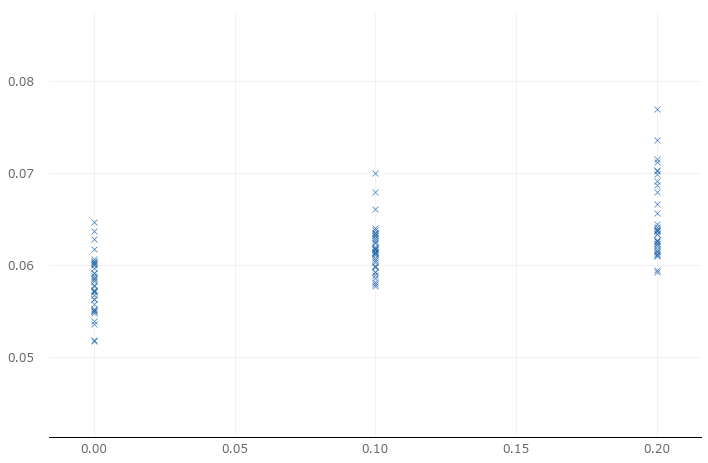

In [235]:
# a regression plot for two dimensions 
r.plot_regs('dropout', 'sum_loss')

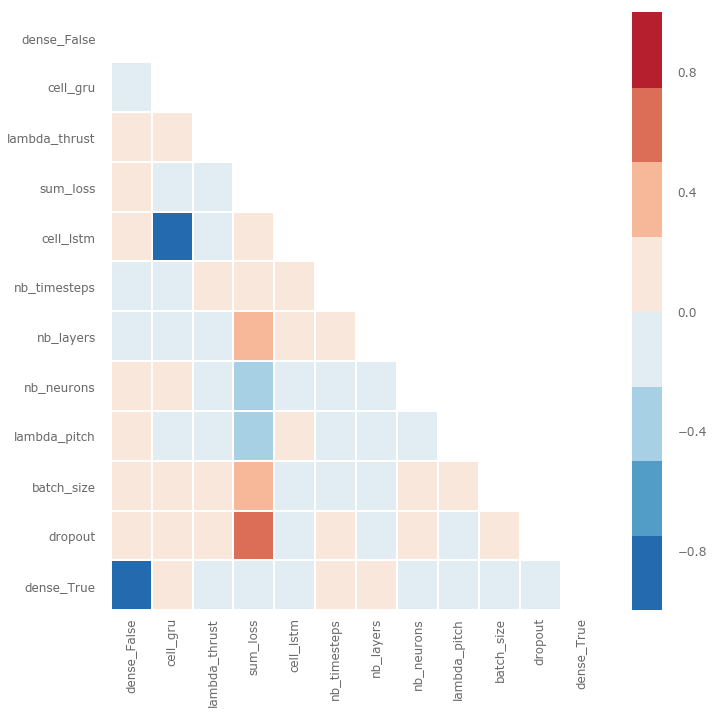

In [236]:
# heatmap correlation
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
r.plot_corr('sum_loss')

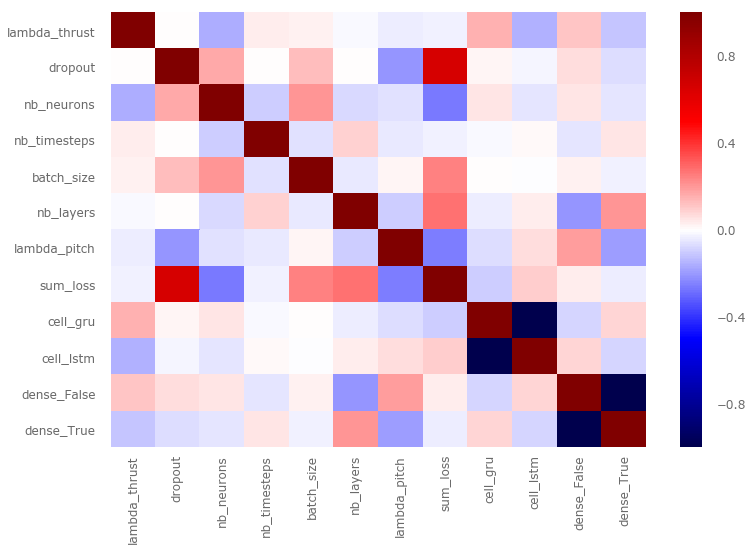

In [237]:
import seaborn as sns
corr = r.data.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           cmap="seismic")

# Conclusions 

Il faut observer la heatmap pour regarder la correlation entre la sum_loss et les hyper-parametres.

* Correlations positives:
    - Dropout: augmenter le dropout augmente la loss
    - Nb_layers: augmenter le nombre de couches du RNN augmente la loss. 
    - Batch_size: idem
=> Il faut baisser le dropout, le nombre de LSTM cells, le batch_size*

* Correlations négatives:
    - Lambda_pitch: un lambda pitch bas signifie que la loss sur le pitch est moins prise en compte que le reste. Puisque le lambda pitch est négativement corrélé, il faut l'augmenter - càd garder une loss équivalente pour pitch roll yaw thrust - pour avoir une faible loss générale.
    - Nb_neurons: + de neurons, moins de loss, on garde bcp de neurones
    
* Indifférents:
    - le nb de timesteps, et la présence d'une dense layer supplémentaire ne changent rien.